<span style="font-weight:bold; font-size:20px;">Import</span>

In [281]:
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder


<span style="font-weight:bold; font-size:20px;">All function</span>

In [3]:
# Data preprocessing
def data_pre(companies):
    for i in companies:
        if 'metadata' in i.keys():
            del i['metadata']
        comp_name = i['name']
        i['name'] = f"{comp_name}_{companies.index(i)}"
        if not isinstance(i['equity_funding_total_usd'], int):
            value = i['equity_funding_total_usd']
            i['equity_funding_total_usd'] = int(value['$numberLong'])
        if i['num_funding_rounds'] is None:
            i['num_funding_rounds'] = 0
    return companies

In [380]:
# The criteria to judge whether the company is successful
def whether_success(companies):
    for i in companies:
        i['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or i['status'] == 'ipo':
                i['startup'] = 'success'
            elif i['num_acquisitions']:
                i['startup'] = 'success'
            # elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 7:
            #     i['startup'] = 'success'
            # elif i['num_funding_rounds'] >= 7:
            #     i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 1000000000:
                i['startup'] = 'success'
            # elif i['valuation_usd']:
            #     if isinstance(i['valuation_usd'], int):
            #         if i['valuation_usd'] >= 1000000000:
            #             i['startup'] = 'success'
            #     else:
            #         if int(i['valuation_usd']['$numberLong']) >= 1000000000:
            #             i['startup'] = 'success'
            elif i['revenue_range'] is not None:
                i['startup'] = 'success'
    return companies

In [401]:
def calculate_success_rate(data, years_threshold):
    subset = [i for i in data if data[i]['Found year'] <= years_threshold]
    if len(subset) == 0:
        return 0
    year_success = [i for i in subset if data[i]['startup'] == 'success']
    return len(year_success) / len(subset)
comp_year_success = {}
for i in data:
    comp_year_success[i['name']] = {'Found year': (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365, 'startup': i['startup']}
for i in [5,11]:
    print(calculate_success_rate(comp_year_success, i))

0.5108748187530208
0.59161


In [400]:
comp_year_success

{'Gro Intelligence_0': {'Found year': 10.635616438356164,
  'startup': 'success'},
 'Squire_1': {'Found year': 9.635616438356164, 'startup': 'success'},
 'The EVERY Company_2': {'Found year': 9.635616438356164,
  'startup': 'success'},
 'Groq_3': {'Found year': 8.635616438356164, 'startup': 'success'},
 'Campus_4': {'Found year': 8.052054794520547, 'startup': 'failed'},
 'Exo_5': {'Found year': 9.635616438356164, 'startup': 'success'},
 'Somatus_6': {'Found year': 8.635616438356164, 'startup': 'success'},
 'Andela_7': {'Found year': 10.252054794520548, 'startup': 'success'},
 'Biobot Analytics_8': {'Found year': 7.632876712328767, 'startup': 'success'},
 'Rockset_9': {'Found year': 8.635616438356164, 'startup': 'success'},
 'Promise_10': {'Found year': 7.632876712328767, 'startup': 'success'},
 'Harness_11': {'Found year': 8.635616438356164, 'startup': 'success'},
 'Bambee_12': {'Found year': 8.219178082191782, 'startup': 'success'},
 'Origin_13': {'Found year': 6.632876712328767, 'sta

In [5]:
# Network building
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G

In [6]:
# Calculate success rate
def success_rate(data, dict, field):
    result = {}
    for i in dict:
        result[i] = 0
        for n in data:
            if isinstance(n[field], list):
                if i in n[field] and n['startup'] == 'success':
                    result[i] += 1
            else:
                if n[field] == i and n['startup'] == 'success':
                    result[i] += 1
    for k in result:
        result[k] = result[k]/dict[k]
    return result

In [128]:
# Calculate component data
def components_data(G):
    result = {}
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        sub_size = len(subgraph)
        sub_success = 0
        for node in subgraph:
            if G.nodes[node]['success'] == 'success':
                sub_success += 1
        sub_success_rate = sub_success/sub_size
        density = nx.density(subgraph)
        for node in subgraph:
            result[node] = {'component_size': sub_size, 'component_success_rate': sub_success_rate, 'component_score':sub_success_rate * density}
    return result

In [154]:
# Basic analysis of the whole network
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None
    # all_path_lengths = []
    # for component in nx.connected_components(G):
    #     subgraph = G.subgraph(component)
        
    #     for node in subgraph.nodes():
    #         path_lengths = nx.single_source_shortest_path_length(subgraph, node)
    #         avg_path_length = sum(path_lengths.values()) / len(path_lengths)
    #         all_path_lengths.append(avg_path_length)

    # if all_path_lengths:
    #     global_avg_path_length = sum(all_path_lengths) / len(all_path_lengths)

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        # "Avg Path Length": global_avg_path_length,
        "Assortativity": net_assortativity}    
    return table

In [23]:
# Generate the features
def generate_feature(G, data):
    degrees = dict(G.degree())
    # clustering = nx.clustering(G)
    closeness = nx.closeness_centrality(G)
    # betweenness = nx.betweenness_centrality(G)
    # eigenvector_centrality = nx.eigenvector_centrality(G)
    # pagerank = nx.pagerank(G)
    
    nodes = [i['name'] for i in data]
    fea_info = {
        'node_id': nodes,
        'degree': [degrees[node] for node in nodes],
        # 'clustering': [clustering[node] for node in nodes],
        'closeness': [closeness[node] for node in nodes],
        # 'betweenness': [betweenness[node] for node in nodes],
        # 'closeness': [closeness[node] for node in nodes],
        # 'eigenvector_centrality': [eigenvector_centrality[node] for node in nodes],
        # 'pagerank': [pagerank[node] for node in nodes],
        'categories': [i['category_groups'] for i in data]
    }
    df = pd.DataFrame(fea_info)
    return df

In [48]:
# Generate neighbors data
def neighbors_score(G, nodes):
    neighbors_sco = []
    for node in nodes:
        score = 0
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            neighbor_status = G.nodes[neighbor]['success']
            edge_weight = G[node][neighbor]['weight']
            if neighbor_status == 'success':
                score += edge_weight
            elif neighbor_status == 'failed':
                score -= edge_weight
        neighbors_sco.append(score)
    return neighbors_sco

In [11]:
# Show the result
def evaluate_pred(model, X_test, y_test, y_pred, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{model_name} ROC AUC Score: {roc_auc:.3f}")
    else:
        print(f"{model_name} does not provide probability predictions for ROC AUC Score.")

<span style="font-weight:bold; font-size:20px;">Data loading and preprocessing</span>

In [71]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [72]:
data = whether_success(data_pre(data[:100000]))

In [381]:
data = whether_success(data)

In [180]:
a = []
for i in data:
    if i['revenue_range'] not in a:
        a.append(i['revenue_range'])
    else:
        continue
a

['r_00001000',
 'r_00010000',
 None,
 'r_00050000',
 'r_00000000',
 'r_00500000',
 'r_01000000',
 'r_00100000',
 'r_10000000']

<span style="font-weight:bold; font-size:20px;">Network building</span>

In [73]:
comps = []
peo = []

for i in data:
    comps.append(i['name'])
    peo.append(list(set(i['founders']) | set(i['investors'])))

In [74]:
G = build_nw(comps, peo)

In [75]:
# Draw LCC here
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(subgraph, pos, with_labels=False, node_color='skyblue', node_size=700, edge_color='gray', width=2)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=12, font_color='red')

plt.title("Network - Largest Connected Component", fontsize=16)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [76]:
node_attri = {}
for index, node in enumerate(G.nodes()):
    node_attri[node] = {}
    node_attri[node]['name'] = data[index]['name']
    node_attri[node]['categories'] = data[index]['category_groups']
    node_attri[node]['success'] = data[index]['startup']
nx.set_node_attributes(G, node_attri)

In [95]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

In [97]:
len(subgraph.nodes())

68256

<span style="font-weight:bold; font-size:20px;">Basic analysis of the whole network</span>

In [155]:
analysis = generate_data(G)
analysis

{'Number of Nodes': 100000,
 'Number of Edges': 10499381,
 'Density': 0.0021,
 'Avg Clustering Coefficient': 0.4665,
 'Avg Degree': 209.9876,
 'Max Degree': 4572,
 'Min Degree': 0,
 'Assortativity': 0.7125}

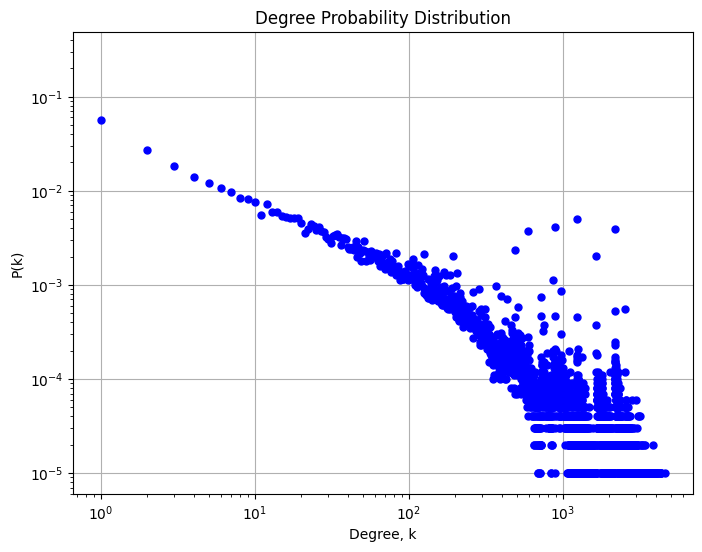

In [212]:
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.nonzero(degree_count)[0]

degree_prob = degree_count[degrees] / float(sum(degree_count))

plt.figure(figsize=(8, 6))
plt.loglog(degrees, degree_prob, 'o', markersize=5, color='blue')
plt.title("Degree Probability Distribution")
plt.xlabel("Degree, k")
plt.ylabel("P(k)")
plt.grid(True)
plt.show()

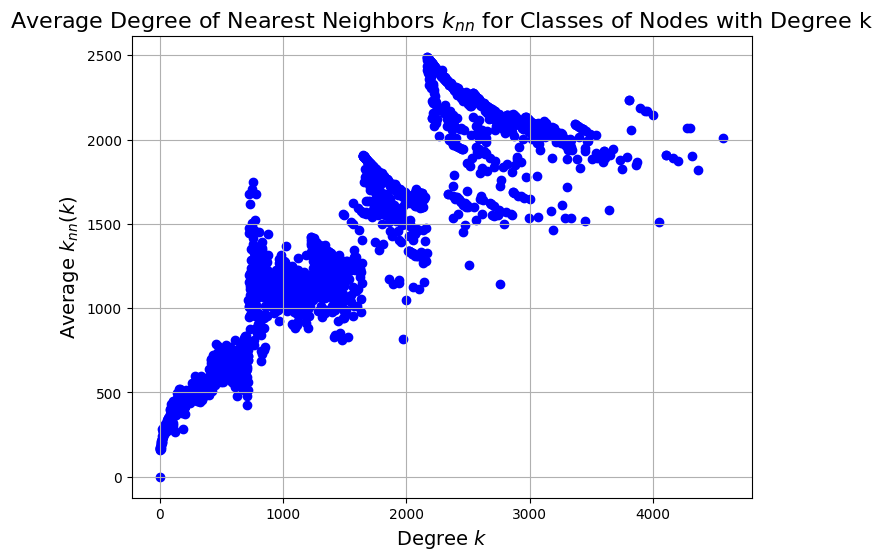

In [149]:
degree_dict = dict(G.degree(weight='weight'))

# 计算每个节点的平均最近邻居度数
knn = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if len(neighbors) > 0:
        knn[node] = sum(degree_dict[neighbor] for neighbor in neighbors) / len(neighbors)
    else:
        knn[node] = 0  # 没有邻居的节点

# 按度数分类并计算平均 knn
degree_knn = {}
for node, k_neigh in knn.items():
    degree = G.degree(node)
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(k_neigh)

average_knn = {k: sum(v) / len(v) for k, v in degree_knn.items()}

# 绘制 knn 的散点图
degrees = list(average_knn.keys())
avg_knn_values = list(average_knn.values())

plt.figure(figsize=(8, 6))
plt.scatter(degrees, avg_knn_values, color='blue')
plt.title("Average Degree of Nearest Neighbors $k_{nn}$ for Classes of Nodes with Degree k", fontsize=16)
plt.xlabel("Degree $k$", fontsize=14)
plt.ylabel("Average $k_{nn}(k)$", fontsize=14)
plt.grid(True)
plt.show()
plt.show()

<span style="font-weight:bold; font-size:20px;">Isolated nodes</span>

In [78]:
isolates = list(nx.isolates(G))
iso_comps = []
found_on = []
funding = []
rounds = []
startup = []
for i in range(len(unique_comps)):
    if unique_comps[i] in isolates:
        iso_comps.append(data[i]['name'])
        found_on.append((datetime.now() - datetime.strptime(data[i]['founded_on'], '%Y-%m-%d')).days)
        funding.append(data[i]['equity_funding_total_usd'])
        rounds.append(data[i]['num_funding_rounds'])
        startup.append(data[i]['startup'])
iso_df = pd.DataFrame({
    'company': iso_comps,
    'days_since_founded': found_on,
    'equity_funding_total_usd': funding,
    'num_funding_rounds': rounds,
    'startup': startup
})
iso_df['num_funding_rounds'] = iso_df['num_funding_rounds'].fillna(0)

In [79]:
# Use Random forests to judge feature importance
X = iso_df.drop(columns=['startup', 'company'])
y = iso_df['startup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Feature combination
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = RandomForestClassifier(random_state=42)
model_poly.fit(X_train_poly, y_train)

# Performance
y_pred = model_poly.predict(X_test_poly)
print("Classification Report with Interaction Features:")
print(classification_report(y_test, y_pred))

<span style="font-weight:bold; font-size:20px;">Non-isolated nodes</span>

In [382]:
data_non_iso = [i for i in data if i['name'] not in isolates]

In [81]:
# Generate the feature dataframe
data_non_iso = [i for i in data if i['name'] not in isolates]
fea_df = generate_feature(G, data_non_iso)

In [83]:
# Caculate the class success rate and closeness
cla = {}
for i in data_non_iso:
    for n in i['category_groups']:
        if not n in cla.keys():
            cla[n] = 1
        else:
            cla[n] += 1
cla_success_rate = success_rate(data_non_iso, cla, 'category_groups')
cla_avg_closeness = {}
for i in cla.keys():
    for n in range(len(fea_df['node_id'])):
        if i in fea_df['categories'][n]:
            if i in cla_avg_closeness:
                cla_avg_closeness[i] += fea_df['closeness'][n]
            else:
                cla_avg_closeness[i] = fea_df['closeness'][n]
for i in cla_avg_closeness:
    cla_avg_closeness[i] = cla_avg_closeness[i]/cla[i]


avg_cla_sco = []
avg_cla_clo = []
for i in fea_df['categories']:
    cla_rates = [cla_success_rate[n] for n in i]
    clo_rates = [cla_avg_closeness[n] for n in i]
    if cla_rates:
        avg_success_rate = sum(cla_rates) / len(cla_rates)
        avg_clo = sum(clo_rates) / len(clo_rates)
        avg_cla_sco.append(avg_success_rate)
        avg_cla_clo.append(avg_clo)
    else:
        avg_cla_sco.append(0)
        avg_cla_clo.append(0)
fea_df['class_score'] = avg_cla_sco
fea_df['class_avg_closeness'] = avg_cla_clo

In [84]:
# Caculate the location success rate
location = {}
for i in data_non_iso:
    if i['location_groups']:
        for n in i['location_groups']:
            if not n in location:
                location[n] = 1
            else:
                location[n] += 1
loc_success_rate = success_rate(data_non_iso, location, 'location_groups')
avg_loc_sco = []
for i in data_non_iso:
    rates = [loc_success_rate[n] for n in i['location_groups']]
    if rates:
        avg_success_rate = sum(rates) / len(rates)
        avg_loc_sco.append(avg_success_rate)
    else:
        avg_loc_sco.append(0)
fea_df['location_score'] = avg_loc_sco

In [85]:
# Caculate the number of employees success rate
employees = {}
for i in data_non_iso:
    if i['num_employees_enum']:
        if not i['num_employees_enum'] in employees:
            employees[i['num_employees_enum']] = 1
        else:
            employees[i['num_employees_enum']] += 1
emp_success_rate = success_rate(data_non_iso, employees, 'num_employees_enum')
avg_emp_sco = []
for i in data_non_iso:
    if i['num_employees_enum']:
        avg_emp_sco.append(emp_success_rate[i['num_employees_enum']])
    else:
        avg_emp_sco.append(0)
fea_df['employees_score'] = avg_emp_sco

In [402]:
employees

{'c_00101_00250': 5379,
 'c_00011_00050': 29294,
 'c_01001_05000': 653,
 'c_00251_00500': 2040,
 'c_00051_00100': 6808,
 'c_00501_01000': 958,
 'c_00001_00010': 23705,
 'c_05001_10000': 96,
 'c_10001_max': 152}

In [403]:
emp_success_rate

{'c_00101_00250': 0.7915969511061536,
 'c_00011_00050': 0.6310507271113539,
 'c_01001_05000': 0.8744257274119449,
 'c_00251_00500': 0.8431372549019608,
 'c_00051_00100': 0.7074030552291422,
 'c_00501_01000': 0.8455114822546973,
 'c_00001_00010': 0.5535962877030163,
 'c_05001_10000': 0.8645833333333334,
 'c_10001_max': 0.8092105263157895}

In [129]:
# Caculate component data
node_component_data = components_data(G)
comp_success_rate = [node_component_data[node]['component_success_rate'] for node in fea_df['node_id']]
comp_size = [node_component_data[node]['component_size'] for node in fea_df['node_id']]
comp_sco = [node_component_data[node]['component_score'] for node in fea_df['node_id']]
fea_df['component_success_rate'] = comp_success_rate
fea_df['component_size'] = comp_size
fea_df['component_score'] = comp_sco

In [87]:
# Caculate neighbors_data
neighbors_data = neighbors_score(G, fea_df['node_id'])
fea_df['neighbors_weighted_success'] = neighbors_data

In [130]:
fea_df

,node_id,degree,closeness,categories,class_score,class_avg_closeness,location_score,employees_score,component_success_rate,component_size,neighbors_weighted_success,component_score
0,Gro Intelligence_0,279,0.245260,"[Agriculture and Farming, Artificial Intellige...",0.624158,0.211965,0.611691,0.791597,0.635607,68256,133,0.002864
1,Squire_1,1739,0.268141,"[Apps, Commerce and Shopping, Mobile, Other, S...",0.623766,0.207056,0.611691,0.791597,0.635607,68256,32,0.002864
2,The EVERY Company_2,304,0.247852,"[Biotechnology, Food and Beverage, Health Care...",0.656156,0.209980,0.601906,0.791597,0.635607,68256,110,0.002864
3,Groq_3,921,0.259102,"[Artificial Intelligence (AI), Consumer Electr...",0.643026,0.214099,0.608419,0.791597,0.635607,68256,290,0.002864
4,Campus_4,207,0.239274,"[Education, Software]",0.627927,0.206463,0.601980,0.631051,0.635607,68256,35,0.002864
...,...,...,...,...,...,...,...,...,...,...,...,...
71045,Rake_99963,5,0.199267,"[Information Technology, Internet Services, Me...",0.624818,0.210742,0.636360,0.631051,0.635607,68256,1,0.002864
71046,KardiaChain_99976,2,0.167292,"[Blockchain and Cryptocurrency, Information Te...",0.591488,0.205316,0.615515,0.631051,0.635607,68256,2,0.002864
71047,JustKapture_99984,5,0.171542,"[Administrative Services, Advertising, Content...",0.654637,0.203245,0.693903,0.553596,0.635607,68256,-1,0.002864
71048,Omnislash Inc_99985,99,0.228331,"[Content and Publishing, Data and Analytics, G...",0.642580,0.203787,0.619360,0.631051,0.635607,68256,15,0.002864


<span style="font-weight:bold; font-size:20px;">Training and prediction</span>

In [383]:
# Split the data
X = fea_df.drop(columns=['node_id', 'categories', 'component_success_rate', 'component_size'])
y = [i['startup'] for i in data_non_iso]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [384]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [385]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
1                   closeness    0.197209
3         class_avg_closeness    0.158782
2                 class_score    0.155294
4              location_score    0.147117
0                      degree    0.132883
6  neighbors_weighted_success    0.130068
5             employees_score    0.072332
7             component_score    0.006315


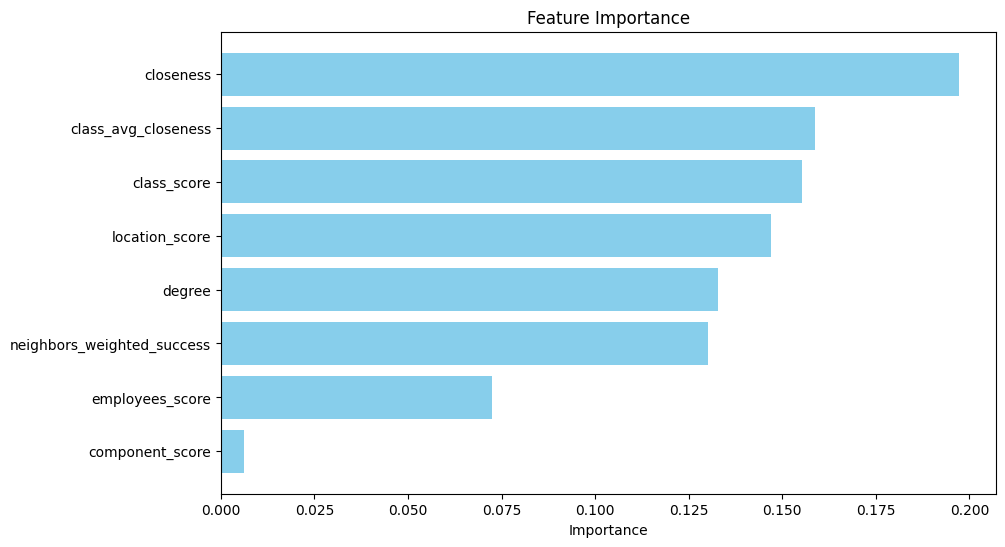

In [386]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 将最高重要性的特征放在最上方

# 显示图表
plt.show()

In [387]:

model_1 = LogisticRegression(class_weight='balanced', max_iter=10000)
model_2 = RandomForestClassifier()
model_3 = SVC(kernel='linear', probability=True)
model_4 = KNeighborsClassifier(n_neighbors=3)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)


In [388]:
y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]
y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]
y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]
y_pred_proba_4 = model_4.predict_proba(X_test)[:, 1]

In [389]:
evaluate_pred(model_1, X_test, y_test, y_pred_1, 'Logistic Regression')
evaluate_pred(model_2, X_test, y_test, y_pred_3, 'Random Forest')
evaluate_pred(model_3, X_test, y_test, y_pred_4, 'SVC')
evaluate_pred(model_4, X_test, y_test, y_pred_5, 'K-Nearest Neighbors')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.53      0.61      0.57      5290
     success       0.75      0.68      0.71      8920

    accuracy                           0.66     14210
   macro avg       0.64      0.65      0.64     14210
weighted avg       0.67      0.66      0.66     14210

Logistic Regression ROC AUC Score: 0.699
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.76      0.13      0.22      5290
     success       0.65      0.98      0.78      8920

    accuracy                           0.66     14210
   macro avg       0.70      0.55      0.50     14210
weighted avg       0.69      0.66      0.57     14210

Random Forest ROC AUC Score: 0.743
SVC Classification Report:
              precision    recall  f1-score   support

      failed       0.56      0.52      0.54      5290
     success       0.73      0.76      0.74      8920


In [390]:
y_random_pred = np.random.choice(['success', 'failed'], size=len(y_test), p=[0.5, 0.5])
random_accuracy = accuracy_score(y_test, y_random_pred)
print(f"Random prediction accuracy: {random_accuracy:.4f}")

Random prediction accuracy: 0.4974


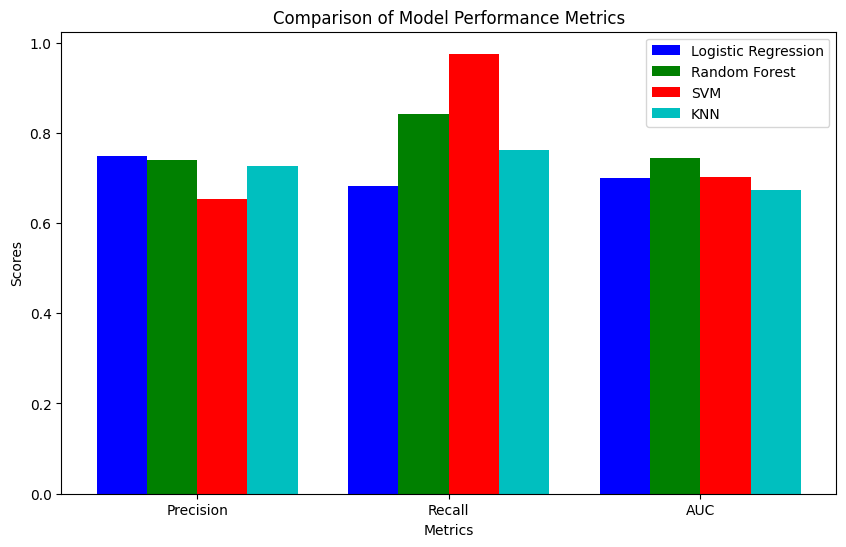

In [391]:

metrics_1 = [precision_score(y_test, y_pred_1, pos_label = 'success'), recall_score(y_test, y_pred_1, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_1)]
metrics_2 = [precision_score(y_test, y_pred_2, pos_label = 'success'), recall_score(y_test, y_pred_2, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_2)]
metrics_3 = [precision_score(y_test, y_pred_3, pos_label = 'success'), recall_score(y_test, y_pred_3, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_3)]
metrics_4 = [precision_score(y_test, y_pred_4, pos_label = 'success'), recall_score(y_test, y_pred_4, pos_label = 'success'), roc_auc_score(y_test, y_pred_proba_4)]

# 定义指标名称和位置
metrics_names = ['Precision', 'Recall', 'AUC']
index = np.arange(len(metrics_names))

# 设置柱宽
bar_width = 0.2

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(index, metrics_1, bar_width, label='Logistic Regression', color='b')
plt.bar(index + bar_width, metrics_2, bar_width, label='Random Forest', color='g')
plt.bar(index + 2 * bar_width, metrics_3, bar_width, label='SVM', color='r')
plt.bar(index + 3 * bar_width, metrics_4, bar_width, label='KNN', color='c')

# 设置图表属性
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance Metrics')
plt.xticks(index + 1.5 * bar_width, metrics_names)
plt.legend()

# 显示图表
plt.show()

In [269]:
# 设定目标节点数和边数
num_nodes = 100000
num_edges = 10499381

# 计算每次添加新节点时连接到现有节点的边数 m
# 注意：m 值必须是一个整数
m = num_edges // num_nodes

# 使用 NetworkX 生成 BA 模型网络
G_test = nx.barabasi_albert_graph(n=num_nodes, m=m)

# 计算实际生成的边数
actual_num_edges = G_test.number_of_edges()
ana_test = generate_data(G_test)
ana_test

{'Number of Nodes': 100000,
 'Number of Edges': 10389184,
 'Density': 0.0021,
 'Avg Clustering Coefficient': 0.0104,
 'Avg Degree': 207.7837,
 'Max Degree': 5430,
 'Min Degree': 104,
 'Assortativity': 0.0021}

In [275]:
print('The performance of Random Forest')
print('Precision of success: 0.70')
print('Recall of success: 0.74')
print('F1 Score of success: 0.72')
print('Accuracy: 0.68')
print('AUC: 0.742')

The performance of Random Forest
Precision of success: 0.70
Recall of success: 0.74
F1 Score of success: 0.72
Accuracy: 0.68
AUC: 0.742


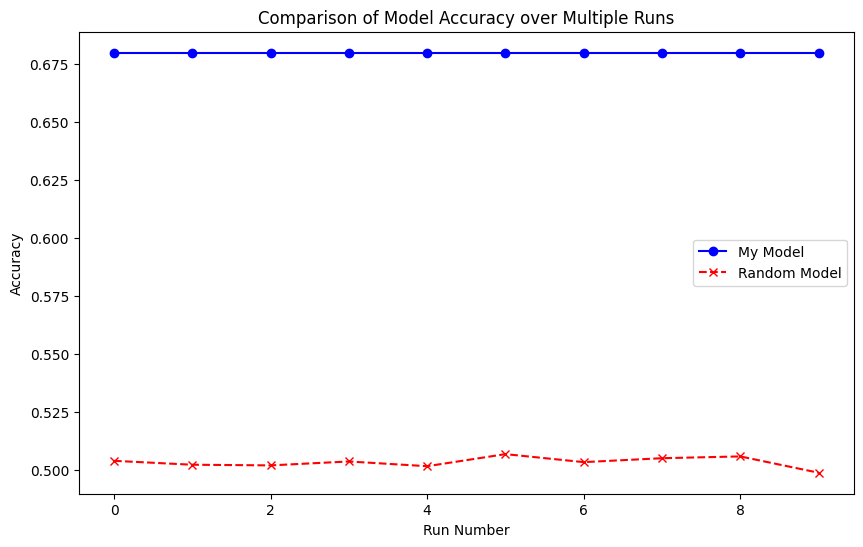

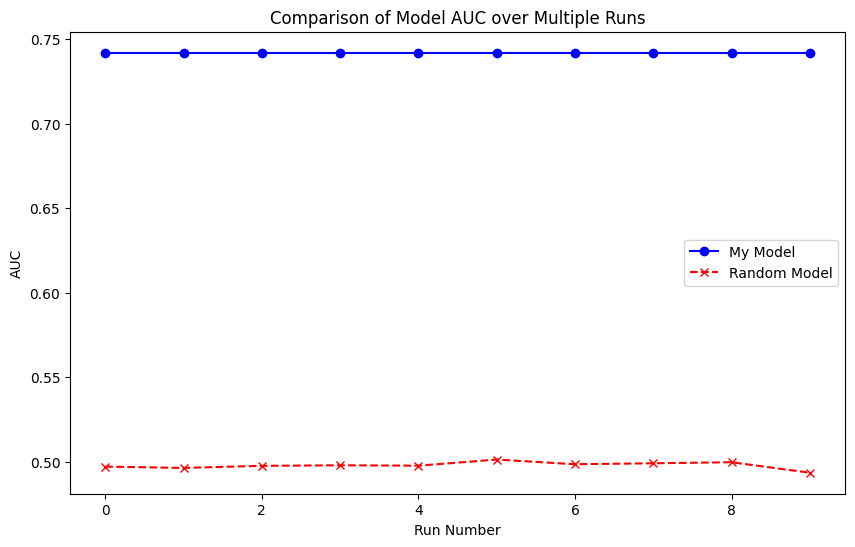

In [288]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
n_runs = 10
random_accuracy = []
random_auc = []
model_accuracy = [0.68] * n_runs
model_auc = [0.742] * n_runs
investment_count = {}
success_count = {}

for i in data_non_iso:
    people = list(set(i['founders']) | set(i['investors']))
    status = i['startup']
    for inv in people:
        if inv in investment_count:
            investment_count[inv] += 1
        else:
            investment_count[inv] = 1
        
        if status == 'success':
            if inv in success_count:
                success_count[inv] += 1
            else:
                success_count[inv] = 1
investor_success_prob = {}
for i in investment_count:
    total_investments = investment_count[i]
    if i in success_count:
        successful_investments = success_count[i]
    else:
        successful_investments = 0
    success_probability = successful_investments / total_investments
    investor_success_prob[i] = {'Total Investments': total_investments, 'Success Probability': success_probability}

# top_20_investors = sorted(investor_success_prob, key=lambda x: x[1], reverse=True)[:20]
# df_top_20 = pd.DataFrame(top_20_investors, columns=['Investor', 'Total Investments', 'Success Probability'])
# print(df_top_20)

y_pred_compare = []
for i in data_non_iso:
    people = list(set(i['founders']) | set(i['investors']))
    total_prob = 0
    for n in people:
        total_prob += investor_success_prob[n]['Success Probability']
    inv_avg_success = total_prob / len(people)
    y_pred_compare.append(inv_avg_success)
for i in range(n_runs):
    y_pred_baseline = np.random.binomial(1, y_pred_compare)
    baseline_accuracy = accuracy_score(y_test_encoded, y_pred_baseline[-len(y_test):])
    baseline_auc = roc_auc_score(y_test_encoded, y_pred_baseline[-len(y_test):])
    random_accuracy.append(baseline_accuracy)
    random_auc.append(baseline_auc)

plt.figure(figsize=(10, 6))
plt.plot(range(n_runs), model_accuracy, label='My Model', color='b', marker='o')
plt.plot(range(n_runs), random_accuracy, label='Random Model', color='r', linestyle='--', marker='x')
plt.xlabel('Run Number')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy over Multiple Runs')
plt.legend()
plt.show()

# 生成AUC的折线图
plt.figure(figsize=(10, 6))
plt.plot(range(n_runs), model_auc, label='My Model', color='b', marker='o')
plt.plot(range(n_runs), random_auc, label='Random Model', color='r', linestyle='--', marker='x')
plt.xlabel('Run Number')
plt.ylabel('AUC')
plt.title('Comparison of Model AUC over Multiple Runs')
plt.legend()
plt.show()

In [289]:
y_test

['failed',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'failed',
 'failed',
 'success',
 'success',
 'failed',
 'success',
 'failed',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'failed',
 'success',
 'failed',
 'failed',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'failed',
 'success',
 'success',
 'failed',
 'success',
 'success',
 'failed',
 'failed',
 'success',
 'failed',
 'failed',
 'failed',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'failed',
 'success',
 'failed',
 'failed',
 'success',
 'success',
 'success',
 'success',
 'failed',
 'success',
 'success',
 'success',
 'success'